In [1]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 939.4 kB/s eta 0:02:13
   ---------------------------------------- 0.1/124.9 MB 939.4 kB/s eta 0:02:13
   ---------------------------------------- 0.1/124.9 MB 939.4 kB/s eta 0:02:13
   ---------------------------------------- 0.1/124.9 MB 939.4 kB/s eta 0:02:13
   ---------------------------------------- 0.3/124.9 MB 999.9 kB/s eta 0:02:05
   ---------------------------------------- 0.6/124.9 MB 1.6 MB/s eta 0:01:18
   ---------------------------------------- 1.0/124.9 MB 2.4 MB/s eta 0:00:52
   ---------------------------------------- 1.3/124.9 MB 3.0 MB/s eta 0:00:41
    ------

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Fungsi untuk mengambil data cuaca dari OpenWeather API
def get_weather_data(api_key, city):
    url = "http://api.openweathermap.org/data/2.5/forecast" 
    params = {"q": city, "appid": api_key, "units": "metric" }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Expection (f"Error fetching data:{response.status_code}")

In [11]:
# Fungsi untuk mengubah data cuaca ke DataFrame
def parse_weather_data(weather_data):
    df = pd.json_normalize(weather_data, record_path= ['list'])
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    df.set_index('dt', inplace=True)
    df = df[['main.temp_max']] # Ambil suhu maksimum
    df.columns = ['Temp_Max'] # Ubah nama kolom
    return df
#Menggunakan API key dan nama kota
API_KEY = '745286da4326bad49f867d2219d898e3'
CITY = 'Jakarta'
#Ambil data cuaca
weather_data = get_weather_data(API_KEY, CITY)
# Parse data ke DataFrame
data = parse_weather_data (weather_data)
#Siapkan data untuk model
data['Hour'] = data.index.hour
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
#Memilih fitur dan target
X = data[['Hour', 'Day', 'Month']]
y = data['Temp_Max']

In [17]:
# Membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Membuat DMatrix untuk XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix (X_test, label=y_test)
# Set parameter untuk XGBoost
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.3, 'learning_rate': 0.1, 
          'max_depth': 5, 'alpha': 10}

In [19]:
#Melatih model
model = xgb.train(params, dtrain, num_boost_round=100)
# Melakukan prediksi
y_pred = model.predict(dtest)
# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 2.54


In [21]:
# Peramalan masa depan (contoh untuk 7 hari ke depan) 
future_hours = np.array([[i% 24, (i// 24) % 7, (i // 24) % 12 + 1] 
                         for i in range(len(data), len(data)+7*24)]) # Hour, Day, Month 
future_df = pd. DataFrame (future_hours, columns=['Hour', 'Day', 'Month'])

# Melakukan prediksi masa depan 
future_dmatrix = xgb.DMatrix (future_df)

# Melakukan prediksi 
future_predictions = model.predict(future_dmatrix)

# Menampilkan prediksi masa depan
future_dates = pd.date_range(start=data.index[-1] + pd. DateOffset(hours=1), 
                             periods=7 * 24, freq='H')
forecast_df = pd. DataFrame({'Forecast_Temp_Max': future_predictions}, index=future_dates)

# Menampilkan hasil prediksi masa depan 
print(forecast_df)

                     Forecast_Temp_Max
2024-10-14 07:00:00          29.815514
2024-10-14 08:00:00          29.815514
2024-10-14 09:00:00          29.815514
2024-10-14 10:00:00          29.815514
2024-10-14 11:00:00          29.815514
...                                ...
2024-10-21 02:00:00          31.661989
2024-10-21 03:00:00          30.353329
2024-10-21 04:00:00          30.353329
2024-10-21 05:00:00          30.353329
2024-10-21 06:00:00          29.815514

[168 rows x 1 columns]


C:\Users\NASWA\AppData\Local\Temp\ipykernel_11456\918569209.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=data.index[-1] + pd. DateOffset(hours=1),


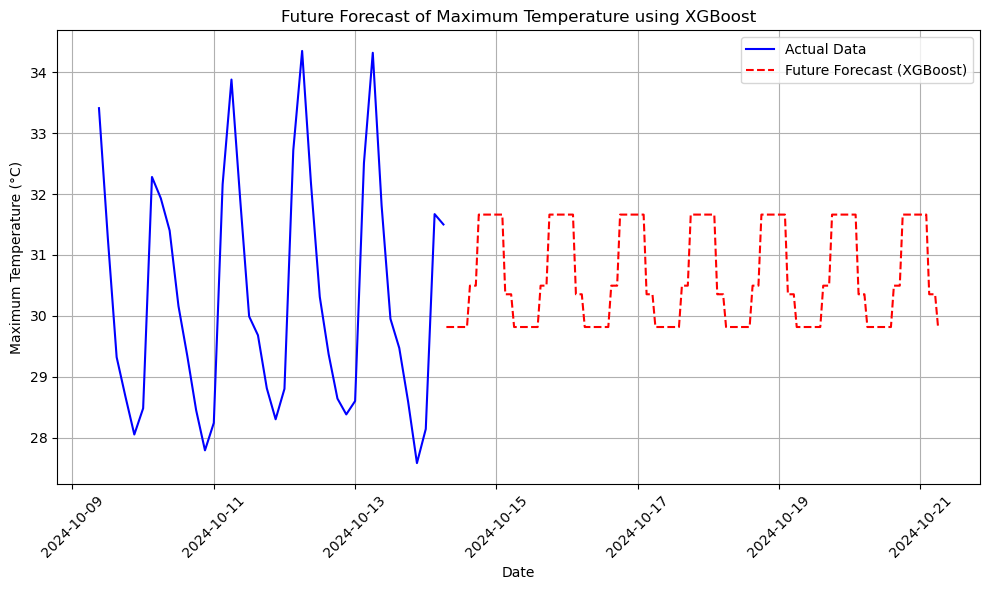

In [23]:
# Plot peramalan masa depan
plt.figure(figsize=(10, 6))
plt.plot(data['Temp_Max'], label='Actual Data', color='blue')
plt.plot(forecast_df, label='Future Forecast (XGBoost)', color='red', linestyle='--')
plt.title('Future Forecast of Maximum Temperature using XGBoost')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()